## Internal Notes: to be deleted.

1 TODO: Let's implement a `return_full_text` field so the user can demand a model
does not include the the input text as well in its response
see https://huggingface.co/docs/transformers/v4.17.0/main_classes/pipelines

2 pip installing Oumi with [.gpu] it does not include ipywidgets which disables the monitoring of 
tqdm inside the notebook and results below in: `TqdmWarning: IProgress not found. Please update jupyter and ipywidgets`
Handling it with `!pip install ipywidgets`, TODO: Can we do better?


# Finetuning a Vision-Language Model (Overview)

In this tutorial, we'll use SFT training to guide a large vision/language model to produce short and concise answer regarding visual input.

We'll use the Oumi framework to streamline the process and achieve high-quality results.

We'll cover the following topics:
1. Prerequisites
2. Data Preparation & Sanity Checks
3. Training Config Preparation
4. Launching Training
5. Analyzing Results
6. Inference


# Prerequisites
## Oumi Installation
First, let's install Oumi. You can find detailed instructions [here](https://github.com/oumi-ai/oumi/blob/main/README.md), but it should be as simple as:

```bash
pip install -e ".[gpu]"  # if you have an nvidia or AMD GPU
# OR
pip install -e "."  # if you don't have a GPU
```

In [ ]:
!pip install ipywidgets # Installing ipywidgets for widget visualization

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false" # deactivate relevant HF warnings

## Creating our working directory

For our experiments, we'll use the following folder to save the model, training artifacts, and our working configs.

In [2]:
from pathlib import Path

tutorial_dir = "vision_language_tutorial"

Path(tutorial_dir).mkdir(parents=True, exist_ok=True)

In what follows we will use the [Qwen2-VL](https://github.com/QwenLM/Qwen2-VL).

Qwen2-VL is a high-performing multi-modal model which uses a modest amount of resources (2B parameters).

We will SFT this model with the [vqav2-small](https://huggingface.co/datasets/merve/vqav2-small) dataset which will help the model respond in a succinct manner on visually grounded questions.

In [3]:
# Initialize our dataset from Oumi & build a tokenizer and an underlying processor.

from oumi.builders import build_tokenizer
from oumi.core.configs import ModelParams
from oumi.datasets.vision_language.vqav2_small import Vqav2SmallDataset

model_name = "Qwen/Qwen2-VL-2B-Instruct"

tokenizer = build_tokenizer(ModelParams(model_name=model_name))

dataset = Vqav2SmallDataset(
    tokenizer=tokenizer,
    processor_name=model_name,
    limit=2000,  # Limit the number of examples for demonstration purposes (!)
)

print("\nExamples included:", len(dataset))

[2025-01-23 11:51:24,542][oumi][rank0][pid:17538][MainThread][INFO]][models.py:422] Using the chat template 'qwen2-vl-instruct', which is the default for model 'Qwen/Qwen2-VL-2B-Instruct'.
[2025-01-23 11:51:24,543][oumi][rank0][pid:17538][MainThread][INFO]][base_map_dataset.py:68] Creating map dataset (type: Vqav2SmallDataset) dataset_name: 'None', dataset_path: 'None'...
[2025-01-23 11:51:26,728][oumi][rank0][pid:17538][MainThread][INFO]][base_map_dataset.py:472] Dataset Info:
	Split: validation
	Version: 0.0.0
	Dataset size: 3391008667
	Download size: 3376516283
	Size: 6767524950 bytes
	Rows: 21435
	Columns: ['multiple_choice_answer', 'question', 'image']
[2025-01-23 11:51:27,529][oumi][rank0][pid:17538][MainThread][INFO]][base_map_dataset.py:411] Loaded DataFrame with shape: (21435, 3). Columns:
multiple_choice_answer    object
question                  object
image                     object
dtype: object


Examples included: 2000


### Let's see a few examples to understand the dataset we are going to use.

Example 1:


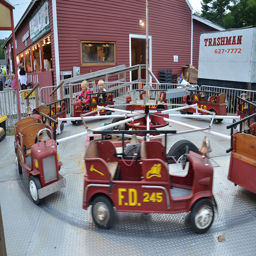

user: [<IMAGE_BINARY>, Where are the kids riding?]...
assistant: carnival ride...


Example 2:


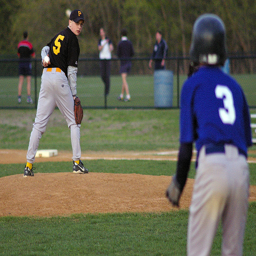

user: [<IMAGE_BINARY>, Is this boy a good pitcher?]...
assistant: yes...




In [4]:
import io

from PIL import Image

from oumi.core.types.conversation import Type

num_examples_to_display = 2

for i in range(num_examples_to_display):
    conversation = dataset.conversation(i)
    print(f"Example {i + 1}:")
    for message in conversation.messages:
        ## More pythonic way to display image below???
        if message.role == "user":  # User poses a question, regarding an image
            img_content = message.content[0]
            assert (
                img_content.type == Type.IMAGE_BINARY
            ), "Oumi encodes image content in binary."
            image = Image.open(io.BytesIO(img_content.binary))
            display(image.resize((256, 256)))  # Resize for display

        print(f"{message.role}: {message.content[:100]}...")  # Truncate for brevity
    print("\n")

In [5]:
# Furthermore, if you want to see directly the underlying stored data, stored in a
# pandas DataFrame, you can do so by running the following command:
dataset.data.head()

,multiple_choice_answer,question,image
0,carnival ride,Where are the kids riding?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,yes,Is this boy a good pitcher?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,wetsuit,What is the person wearing?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,4,How many sinks are in this bathroom?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,soccer,What sport are the girls playing?,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


## Initial Model Responses

Let's see how our model performs on an example prompt without any finetuning.

In [6]:
%%writefile $tutorial_dir/infer.yaml

model:
  model_name: "Qwen/Qwen2-VL-2B-Instruct"
  torch_dtype_str: "bfloat16" # bfloat16 is a good choice if you have access to an    Ampere or newer GPIU
  chat_template: "qwen2-vl-instruct"
  model_max_length: 4096
  trust_remote_code: True
  
generation:
  max_new_tokens: 64
  batch_size: 1
  
engine: NATIVE # Let's use the `native` machine engine for inference.  
# Please consider VLLM if available for much faster inference. 
# To install it with Oumi: 
# pip install ".[optional]"

Writing vision_language_tutorial/infer.yaml


In [12]:
from oumi.core.configs import InferenceConfig
from oumi.infer import infer

config = InferenceConfig.from_yaml(str(Path(tutorial_dir) / "infer.yaml"))

# Use the data of the ith (here 0) conversation as input
conversation_id = 0
query_img = dataset.conversation(conversation_id).messages[0].image_content_items
query_text = dataset.conversation(conversation_id).messages[0].text_content_items

print(query_text)

results = infer(
    config=config,
    inputs=[str(query_text[0])],
    # inputs=["Desrcibe the image"],
    input_image_bytes=query_img[0].binary,
)[0]

[2025-01-23 11:56:02,865][oumi][rank0][pid:17538][MainThread][INFO]][models.py:186] Building model using device_map: auto (DeviceRankInfo(world_size=1, rank=0, local_world_size=1, local_rank=0))...
[2025-01-23 11:56:02,865][oumi][rank0][pid:17538][MainThread][INFO]][models.py:256] Using model class: <class 'transformers.models.auto.modeling_auto.AutoModelForVision2Seq'> to instantiate model.


[Where are the kids riding?]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[2025-01-23 11:56:05,714][oumi][rank0][pid:17538][MainThread][INFO]][models.py:422] Using the chat template 'qwen2-vl-instruct', which is the default for model 'Qwen/Qwen2-VL-2B-Instruct'.
[2025-01-23 11:56:07,153][oumi][rank0][pid:17538][MainThread][INFO]][native_text_inference_engine.py:105] Setting EOS token id to `151645`


In [99]:
results.last_message().text_content_items[0].content

'kids are riding(295,295),(419,426)'

Top Left: (295, 295)
Bottom Right: (419, 426)


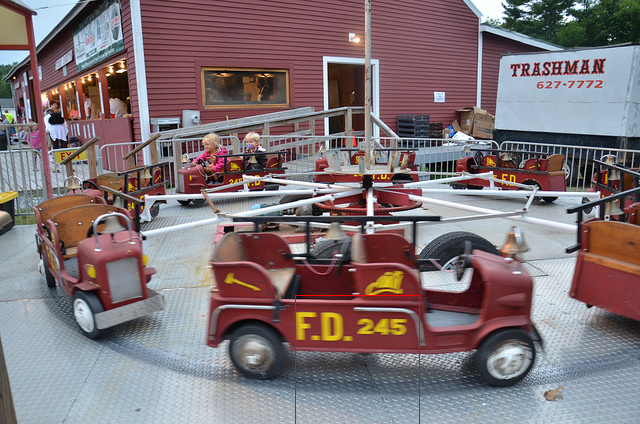

In [101]:
## Presumably the model has tried to respond aboce by giving the (X_top_left, Y_top_left).
# coordinates of the bounding box capturing the action asked for in the image.

import re 
# Regular expression pattern to extract coordinates
pattern = r"\((\d+),(\d+)\)\,\(\d+,\d+\)"

input_str = results.last_message().text_content_items[0].content
match = re.search(pattern, input_str)

if match:
    x_top_left, y_top_left = map(int, match.groups())  # Extract first coordinate pair
    bottom_match = re.findall(r"\((\d+),(\d+)\)", input_str)

    if len(bottom_match) >= 2:  # Ensure we have at least two coordinate pairs
        x_bottom_right, y_bottom_right = map(int, bottom_match[1])

        # Assign values
        top_left = (x_top_left, y_top_left)
        bottom_right = (x_bottom_right, y_bottom_right)

        print(f"Top Left: {top_left}")
        print(f"Bottom Right: {bottom_right}")
    else:
        print("Error: Not enough coordinates found.")
else:
    print("Error: Failed to extract the required coordinates.")

from PIL import ImageDraw
    
if match:
    # Load the image
    query_img_bytes = query_img[0].binary
    image = Image.open(io.BytesIO(query_img_bytes))

    # Draw the bounding box
    draw = ImageDraw.Draw(image)
    draw.rectangle([top_left, bottom_right], outline="red", width=1)

    # Show the image with bounding box
    display(image)

In [ ]:
%%writefile $tutorial_dir/train.yaml

model:
  model_name: "Qwen/Qwen2-VL-2B-Instruct"
  torch_dtype_str: "bfloat16"
  model_max_length: 4096
  trust_remote_code: True
  attn_implementation: "sdpa"
  chat_template: "qwen2-vl-instruct"
  freeze_layers:
    - "visual"     # Let's train only the language component of the model for faster training

data:
  train:
    collator_name: "vision_language_with_padding" # simple padding collator
    datasets:
      - dataset_name: "merve/vqav2-small"
        split: "validation" # This dataset has only a validation split
        shuffle: True
        seed: 42
        transform_num_workers: "auto"
        dataset_kwargs:
          processor_name: "Qwen/Qwen2-VL-2B-Instruct" # i.e., the default for our model
          limit: 4096
          return_tensors: True      

training:
  output_dir: "vision_language_tutorial"
  trainer_type: "TRL_SFT"
  enable_gradient_checkpointing: True
  per_device_train_batch_size: 1 # Must be 1: the model generates variable-sized image features.
  gradient_accumulation_steps: 32
  
  # ***NOTE***
  # We set it to 10 steps to first verify that it works
  # Swap to num_train_epochs: 1 to get more meaningful results.
  # Note: 1 training epoch will take XXX hours on a single A100-40GB GPU.
  # max_steps: 20
  num_train_epochs: 1

  gradient_checkpointing_kwargs:
    # Reentrant docs: https://pytorch.org/docs/stable/checkpoint.html#torch.utils.checkpoint.checkpoint
    use_reentrant: False
  ddp_find_unused_parameters: False
  empty_device_cache_steps: 1

  optimizer: "adamw_torch_fused"
  learning_rate: 2e-5
  warmup_ratio: 0.03
  weight_decay: 0.0
  lr_scheduler_type: "cosine"

  logging_steps: 5
  save_steps: 0
  dataloader_main_process_only: False
  dataloader_num_workers: 2
  dataloader_prefetch_factor: 8
  include_performance_metrics: True
  enable_wandb: True # Set to False if you don't want to use Weights & Biases

In [ ]:
!oumi train -c "$tutorial_dir/train.yaml"

## Use the Fine-tuned Model

Once we're happy with the results, we can serve the fine-tuned model for interactive inference:

In [ ]:
%%writefile $tutorial_dir/trained_infer.yaml

model:
  model_name: "vision_language_tutorial"  
  torch_dtype_str: "bfloat16" # Assumes your GPU supports bfloat16 (Ampere or newer)
  chat_template: "qwen2-vl-instruct"
  model_max_length: 4096
  trust_remote_code: True

generation:
  max_new_tokens: 64
  batch_size: 1
  
engine: NATIVE 

In [ ]:
config = InferenceConfig.from_yaml(str(Path(tutorial_dir) / "trained_infer.yaml"))

# Use the data of the first conversation as input
query_img = dataset.conversation(0).messages[0].image_content_items
query_text = dataset.conversation(0).messages[0].text_content_items

print(query_text)

results = infer(
    config=config,
    inputs=[str(query_text[0])],
    # inputs=["Desrcibe the image"],
    input_image_bytes=query_img[0].binary,
)[0]

print(results.last_message().text_content_items[0].content)